### Load Libraries

In [1]:
# To import your own module from a subdirectory, you can use sys.path or install as a package.
# Example using sys.path (assuming HP-Operation is a folder with __init__.py):

import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import os
sys.path.append(os.path.abspath("../../src/"))  # now src is on sys.path
import HP_Operation as tool

%load_ext autoreload
%autoreload 2

### Read PV profile and Statistical Data, and Basic Load 

In [2]:
# Set random seed for reproducibility
np.random.seed(0)

# Path to your Excel file
file_path = 'data/PV_Profile_Cyprus.xlsx'

# Read the Excel file into a DataFrame
PV_profile_Cyprus = pd.read_excel(file_path,index_col=0) # 24 hour per kw historical rooftop production for different months 
PV_profile_Cyprus=PV_profile_Cyprus*1.3

file_path = 'data/annual_consumption_profiles_cyprus.npy'  # A lot of load profiles from nandos (Australia)
Load_profile_cyprus=np.load(file_path)/1000
Load_profile_cyprus=Load_profile_cyprus*1.1
# Load_profile_cyprus=load_profile_cyprus/1000

# Read the specified sheet into a DataFrame
PV_Data = pd.read_excel('data/PV_Insallation_Historical_Data.xlsx')

# Drop rows where 'Power' or 'Phase' columns have NaN values
PV_Data = PV_Data.dropna(subset=['Power', 'Phase'])

### Filter the basic load profiles without heating systems.

In [3]:
# Reshape to (68, 17568)
profiles = Load_profile_cyprus.reshape(68, -1)
dt_index = pd.date_range("2016-01-01", periods=366*48, freq="30min")

# Monthly means per customer 
monthly_means = pd.DataFrame(index=range(68), columns=range(1, 13))
for customer_id in range(68):
    s = pd.Series(profiles[customer_id], index=dt_index)
    for month in range(1, 13):
        monthly_means.loc[customer_id, month] = s[s.index.month == month].mean()

monthly_means = monthly_means.astype(float)

# seasonal mean values
winter_mean = monthly_means[[12, 1, 2]].sum(axis=1)
autumn_mean = monthly_means[[9, 10, 11]].sum(axis=1)

# Thermal customer = winter/summer > threshold
threshold = 1.6
heating_flags = (winter_mean / autumn_mean) > threshold
heating_customers = monthly_means.index[heating_flags].tolist()

print("❄️ Suspected heating customers:", heating_customers)

# Customer without electric heating consumption
non_heating_customers = np.setdiff1d(np.arange(68), heating_customers)

# Kepp only non-heating customers
profiles_no_heating = profiles[non_heating_customers]  # shape (N, 17568)

❄️ Suspected heating customers: [7, 14, 19, 23, 27, 32, 33, 34, 42, 46, 52]


### The random generation profiles for 90 Customers are generating in this code

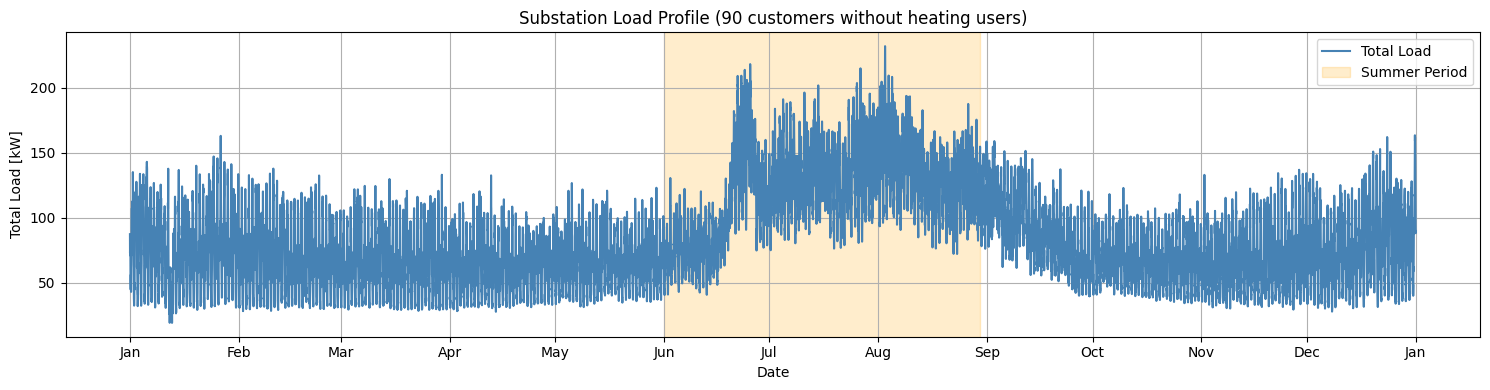

In [4]:
substation_customers=90

# profiles_no_heating: has shape (N_customers, 17568)
N_customers = profiles_no_heating.shape[0]  # e.g. 63

# 1. All Customers without repeatition
unique_customers = np.arange(N_customers)

# 2. How many extra customers do we need to reach substation_customers?
N_extra = substation_customers - N_customers

# 3. Randomly choose extra customer (repeatition allowed)
extra_customers = np.random.choice(N_customers, size=N_extra, replace=True)

# 4. Final list of customers
total_customers = np.concatenate([unique_customers, extra_customers])

# 5. Total load profile
substation_profiles = profiles_no_heating[total_customers]  # shape = (90, 17568)
substation_total_load = substation_profiles.sum(axis=0)

# 6. Create series for plotting
time_index = pd.date_range("2016-01-01", periods=17568, freq="30min")
load_series = pd.Series(substation_total_load, index=time_index)

# 7. Plot
plt.figure(figsize=(15, 4))
plt.plot(load_series, color='steelblue', label='Total Load')

# Highlight summer period
plt.axvspan(pd.Timestamp('2016-06-01'), pd.Timestamp('2016-08-30'), 
            color='orange', alpha=0.2, label='Summer Period')

plt.title("Substation Load Profile (90 customers without heating users)")
plt.xlabel("Date")
plt.ylabel("Total Load [kW]")
plt.grid(True)
plt.legend()
# Format x-axis to show only month names
month_formatter = mdates.DateFormatter('%b')  # e.g. Jan, Feb, ...
plt.gca().xaxis.set_major_formatter(month_formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()
plt.show()

### Representative PV profile for each month as readen by DSO data is plotted below

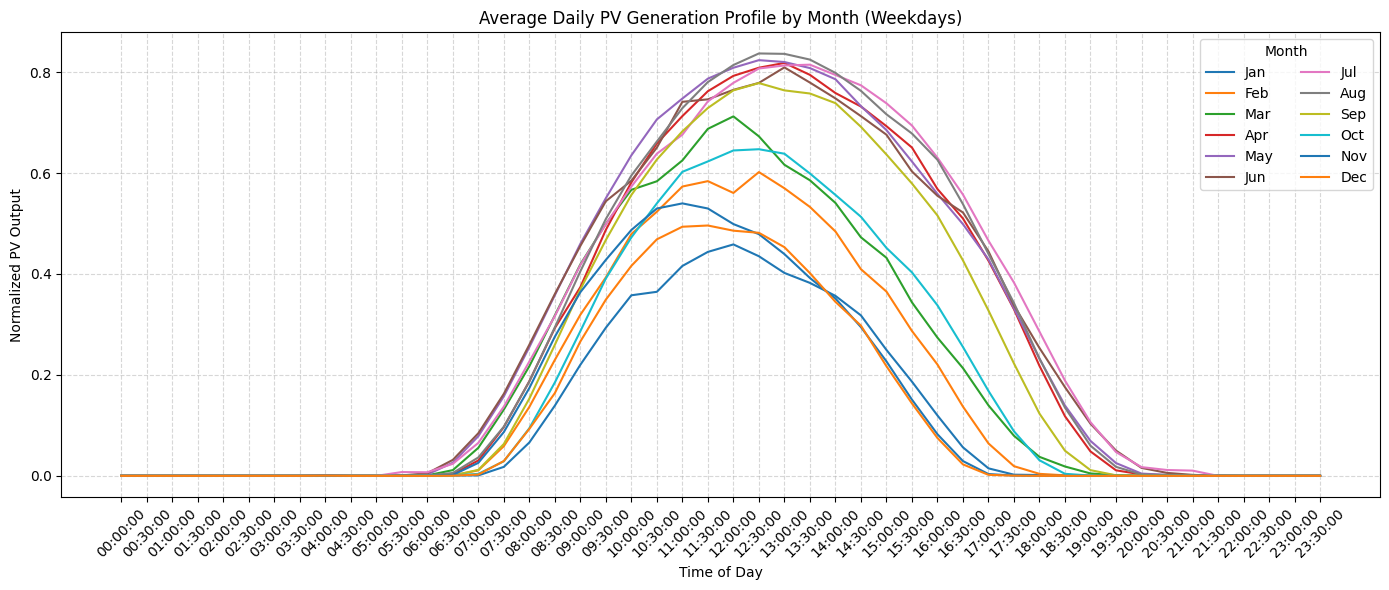

In [5]:
# Months for each column
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# x axes labels
time_labels = PV_profile_Cyprus.index.astype(str)

# create figure
plt.figure(figsize=(14, 6))

# Loop for each month
for month in months:
    col = f"{month}_WD"
    plt.plot(time_labels, PV_profile_Cyprus[col], label=month)

# plot 
plt.title("Average Daily PV Generation Profile by Month (Weekdays)")
plt.xlabel("Time of Day")
plt.ylabel("Normalized PV Output")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Month", loc='upper right', ncol=2)
plt.tight_layout()
plt.show()


### The same profile for each day of the month is made here to be ready to make summation with the basic load profile and heating load profile

In [6]:
# 1. Number of customers
N_total_customers = substation_customers

# 2. Penetration level of PVs
penetration = 0.3  

# 3. Randomly select nominal installed power of PV customers
N_pv_customers = int(N_total_customers * penetration)
selected_customers = PV_Data.sample(n=N_pv_customers, replace=False, random_state=42).reset_index(drop=True)

# 4. create pv profile list for 2016 (366 ημέρες)
daily_pv_profiles = []  # it will have shape (366, 48)

# Create a date range for 2016
days_2016 = pd.date_range(start="2016-01-01", end="2016-12-31", freq="D")

for day in days_2016:

    month_abbr = day.strftime("%b")  # e.g. Jan
    profile_column = f"{month_abbr}_WD"
    daily_profile = PV_profile_Cyprus[profile_column].values  # shape (48,)
    daily_pv_profiles.append(daily_profile)

# Add all values in a  single array (366, 48)
daily_pv_profiles = np.array(daily_pv_profiles)

# Reshape to (366*48 = 17568,)
base_profile = daily_pv_profiles.reshape(-1)  # normalized

# 5. create generation profile for each customer
PV_profiles = []

for i in range(N_pv_customers):
    power = selected_customers.loc[i, "Power"]  # power of each producer
    power = float(selected_customers.loc[i, "Power"])
    customer_profile = base_profile * power  # ration of generation
    PV_profiles.append(customer_profile)

PV_profiles = np.array(PV_profiles)  # shape: (N_pv_customers, 17568)

print(f"✅ PV_profiles shape: {PV_profiles.shape}")


✅ PV_profiles shape: (27, 17568)


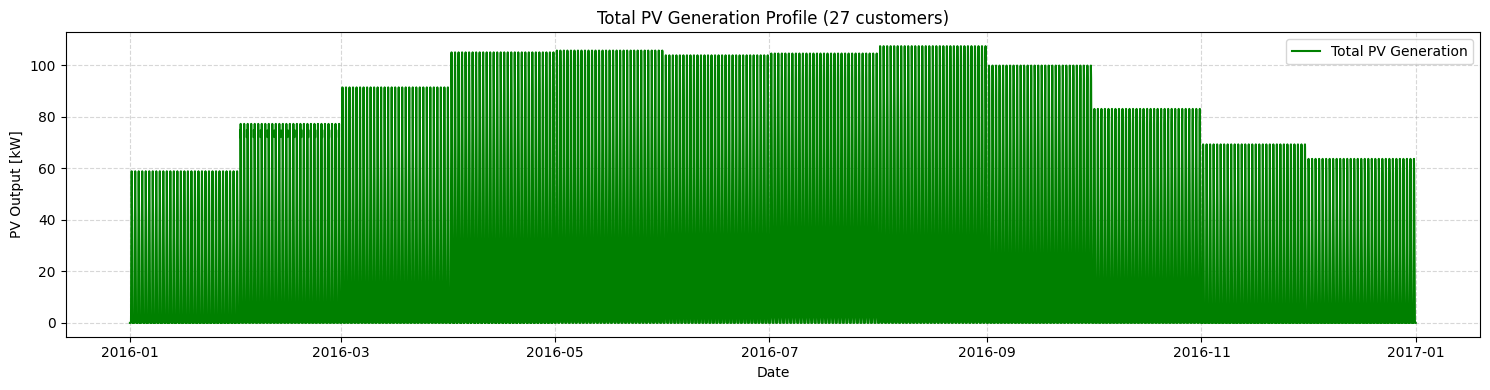

In [7]:
PV_profiles.shape == (N_pv_customers, 17568)
# Summarize the PV generation profiles
total_pv_generation = PV_profiles.sum(axis=0)  # shape = (17568,)

# Create a time index for the entire year
time_index = pd.date_range(start="2016-01-01", periods=17568, freq="30min")

# Create Series
pv_series = pd.Series(total_pv_generation, index=time_index)
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(pv_series, color='green', label='Total PV Generation')
plt.title(f"Total PV Generation Profile ({N_pv_customers} customers)")
plt.xlabel("Date")
plt.ylabel("PV Output [kW]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()

### The same plot as above was made here but included PV profile in basic load profile

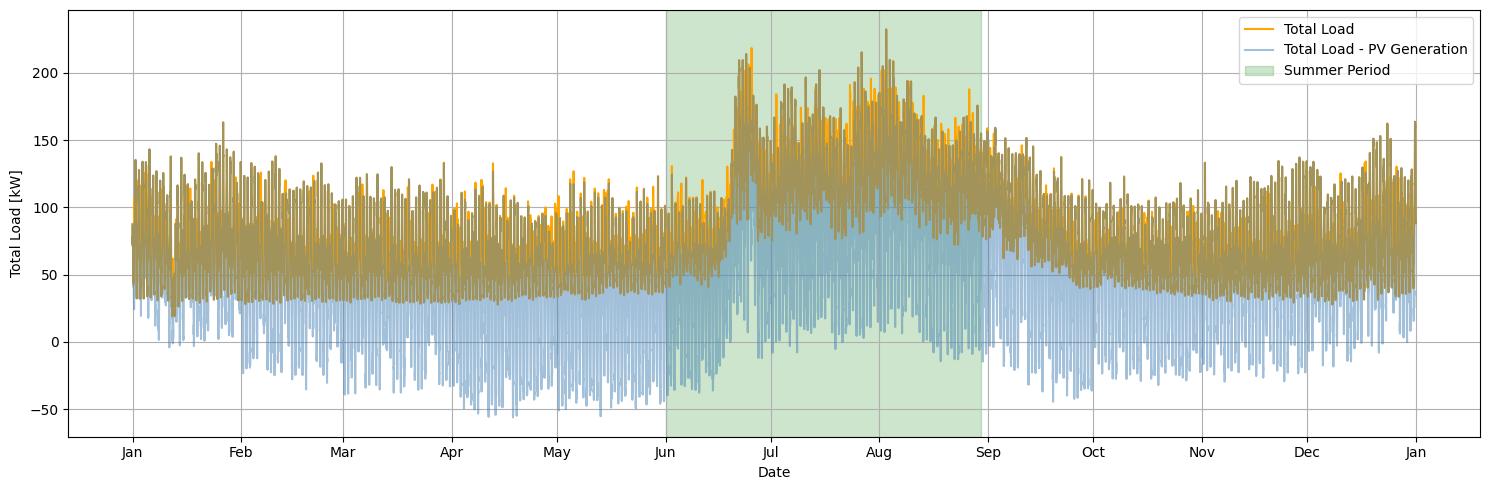

In [8]:
june_start = "2016-06-01"
june_end = "2016-06-30"

load_june = load_series[june_start:june_end]
pv_june = pv_series[june_start:june_end]

plt.figure(figsize=(15, 5))
plt.plot(load_series, color='orange', label='Total Load')
plt.plot(load_series-pv_series, color='steelblue', label='Total Load - PV Generation',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Total Load [kW]")
plt.grid(True)

# Highlight summer period
plt.axvspan(pd.Timestamp('2016-06-01'), pd.Timestamp('2016-08-30'), 
            color='green', alpha=0.2, label='Summer Period')
# Format x-axis to show only month names
month_formatter = mdates.DateFormatter('%b')  # e.g. Jan, Feb, ...
plt.legend()
plt.gca().xaxis.set_major_formatter(month_formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()
plt.show()



### A specific time period is plotted here 

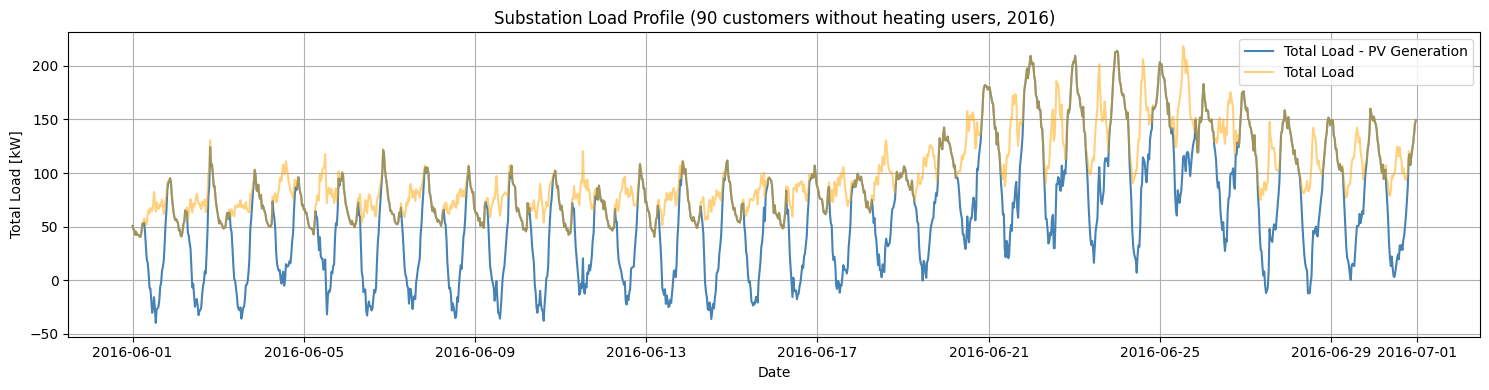

In [9]:
june_start = "2016-06-01"
june_end = "2016-06-30"

load_june = load_series[june_start:june_end]
pv_june = pv_series[june_start:june_end]

plt.figure(figsize=(15, 4))
plt.plot(load_series[june_start:june_end]-pv_series[june_start:june_end], color='steelblue', label='Total Load - PV Generation')
plt.plot(load_series[june_start:june_end], color='orange', label='Total Load',alpha=0.5)
plt.title("Substation Load Profile (90 customers without heating users, 2016)")
plt.xlabel("Date")
plt.ylabel("Total Load [kW]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Categorised the data based on the season

In [10]:
# Define months for each season.
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11]
}

# Create an empty dictionary to store the average daily profiles for each season.
season_profiles = {}

for season, months in seasons.items():
    # Filter the load series for the current season.
    mask = load_series.index.month.isin(months)
    season_data = load_series[mask]

    # Calculate the number of days in the season.
    n_days = int(len(season_data) / 48)
    
    # Reshape to (dates, 48)
    daily_matrix = season_data.values[:n_days * 48].reshape(n_days, 48)

    # Calculate the average daily profile for the season.
    avg_daily_profile = daily_matrix.mean(axis=0)

    # Save the average daily profile in the dictionary.
    season_profiles[season] = avg_daily_profile


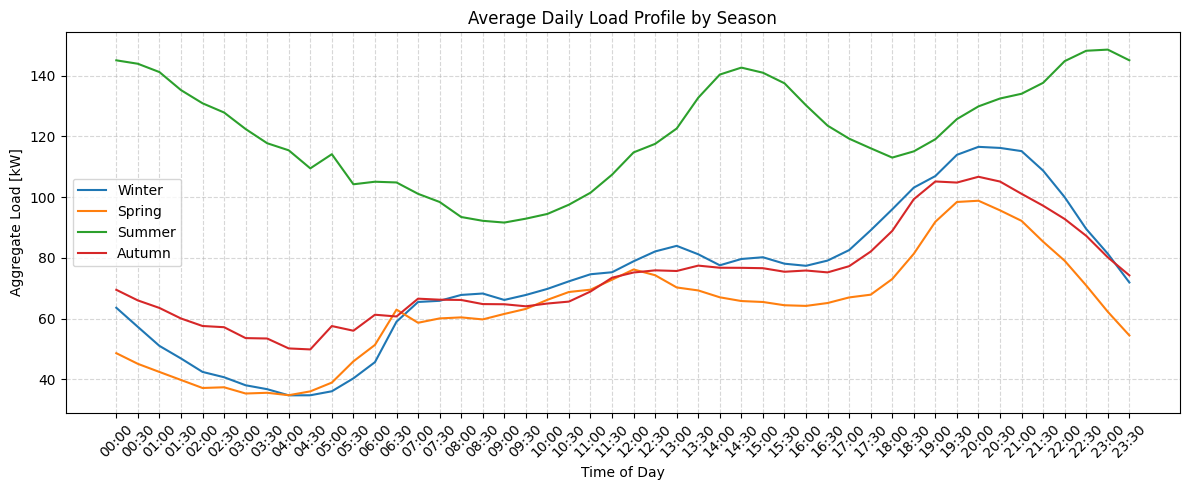

In [11]:
# Create a time index for the x-axis.
time_labels = [f"{h:02d}:{m:02d}" for h in range(24) for m in (0, 30)]

plt.figure(figsize=(12, 5))

for season, profile in season_profiles.items():
    plt.plot(time_labels, profile, label=season)

plt.title("Average Daily Load Profile by Season")
plt.xlabel("Time of Day")
plt.ylabel("Aggregate Load [kW]")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


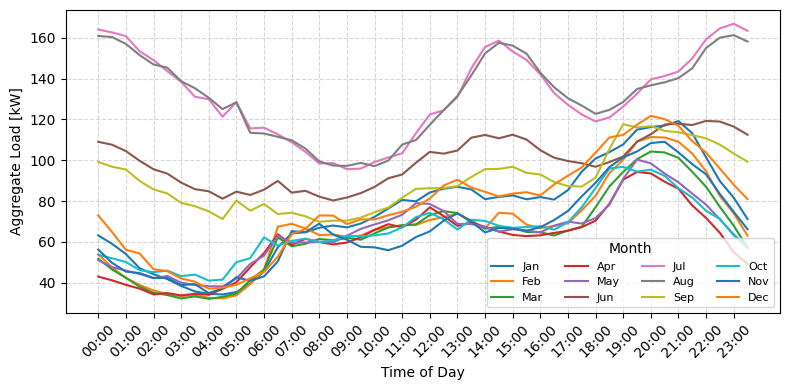

In [12]:
# Dictionary to store monthly average daily profiles
monthly_profiles = {}

# Compute the average daily profile for each month
for month in range(1, 13):
    mask = load_series.index.month == month
    month_data = load_series[mask]
    n_days = int(len(month_data) / 48)
    daily_matrix = month_data.values[:n_days * 48].reshape(n_days, 48)
    avg_profile = daily_matrix.mean(axis=0)
    monthly_profiles[month] = avg_profile

# Time labels for 30-minute intervals, but display only hourly ticks
time_labels = [f"{h:02d}:{m:02d}" for h in range(24) for m in (0, 30)]
hourly_ticks = [i for i in range(48) if i % 2 == 0]  # every hour

# Plotting
plt.figure(figsize=(8,4))
for month in range(1, 13):
    label = pd.to_datetime(f"2023-{month:02d}-01").strftime('%b')
    plt.plot(monthly_profiles[month], label=label)

plt.xlabel("Time of Day")
plt.ylabel("Aggregate Load [kW]")
plt.xticks(ticks=hourly_ticks, labels=[time_labels[i] for i in hourly_ticks], rotation=45)
plt.legend(title="Month", ncol=4,fontsize=8, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



#### Here the initial Analysis of Basic Load without Heating Systems is done

## From now and then the analysis will be start to calculate heating power demand for one representative Cyprus building

In [13]:
ashp1_floor_heating = tool.HeatPumpModel(name="ASHP 1", a0=5.06, a1=-0.05, a2=0.00006, gamma_corr=0.85)
ashp1_floor_heating.generate_cop_curve(np.round(np.arange(10, 61.1,0.1),2))
ashp1_floor_heating.generate_sink_temp_curve(27.98,-0.33,-0.0039, np.round(np.arange(-10,15.1,0.1),2))

ashp2_fan_coil = tool.HeatPumpModel(name="ASHP 2", a0=5.06, a1=-0.05, a2=0.00006, gamma_corr=0.85)
ashp2_fan_coil.generate_cop_curve(np.round(np.arange(10, 61.1,0.1),2))
ashp2_fan_coil.generate_sink_temp_curve(32.84,-0.56,-0.0051, np.round(np.arange(-10,15.1,0.1),2))

ashp3_low_radiator = tool.HeatPumpModel(name="ASHP 3", a0=5.06, a1=-0.05, a2=0.00006, gamma_corr=0.85)
ashp3_low_radiator.generate_cop_curve(np.round(np.arange(10, 61.1,0.1),2))
ashp3_low_radiator.generate_sink_temp_curve(36.67,-0.78,-0.0040, np.round(np.arange(-10,15.1,0.1),2))

ashp4_medium_radiator = tool.HeatPumpModel(name="ASHP 4", a0=5.06, a1=-0.05, a2=0.00006, gamma_corr=0.85)
ashp4_medium_radiator.generate_cop_curve(np.round(np.arange(10, 61.1,0.1),2))
ashp4_medium_radiator.generate_sink_temp_curve(42.14,-0.96,-0.0062, np.round(np.arange(-10,15.1,0.1),2))


In [14]:
# Path to your Excel file
file_path = 'data/TRNSYS_houses_results.xlsx'

# Read the Excel file into a DataFrame
Thermal_Power = pd.read_excel(file_path,index_col=0, sheet_name="Lefkosia", usecols=["Time [h]", "Heat [kW]", "Tamb"])


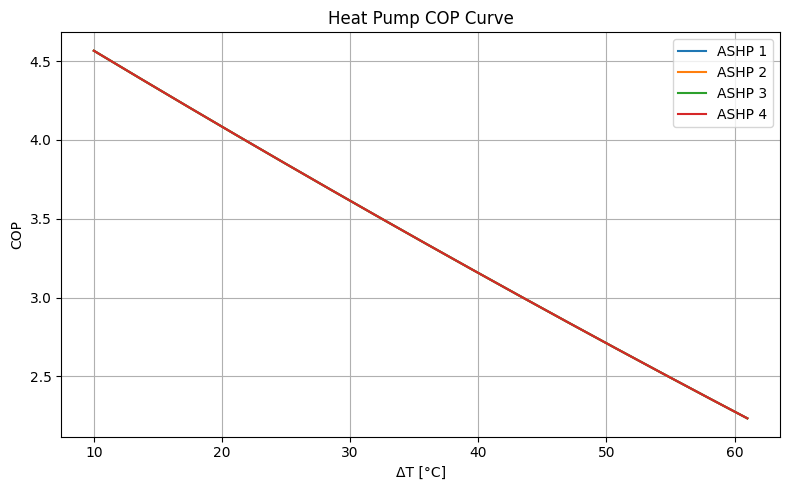

In [15]:
# Plot the COP curve
plt.figure(figsize=(8, 5))
plt.plot(ashp1_floor_heating.cop_table.index, ashp1_floor_heating.cop_table["COP"], linestyle='-')
plt.plot(ashp2_fan_coil.cop_table.index, ashp2_fan_coil.cop_table["COP"], linestyle='-')
plt.plot(ashp3_low_radiator.cop_table.index, ashp3_low_radiator.cop_table["COP"], linestyle='-')
plt.plot(ashp4_medium_radiator.cop_table.index, ashp4_medium_radiator.cop_table["COP"], linestyle='-')

plt.title("Heat Pump COP Curve")
plt.xlabel("ΔT [°C]")
plt.ylabel("COP")
plt.legend([ashp1_floor_heating.name, ashp2_fan_coil.name, ashp3_low_radiator.name, ashp4_medium_radiator.name])
plt.grid(True)
plt.tight_layout()
plt.show()

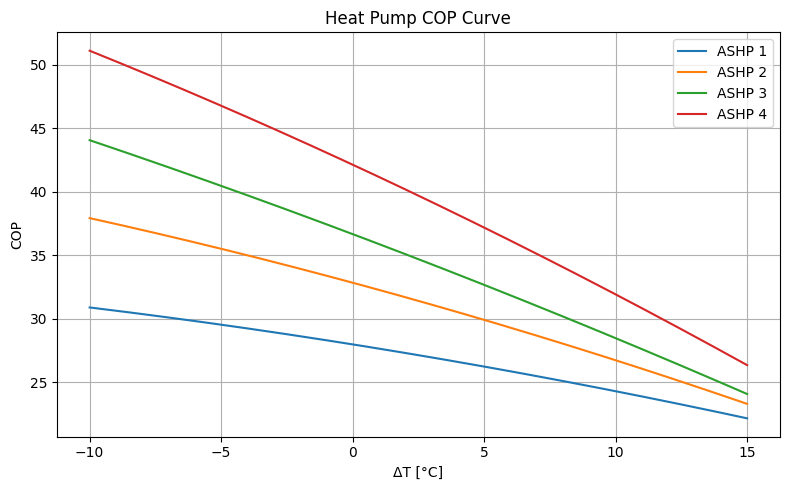

In [16]:
# Plot the COP curve
plt.figure(figsize=(8, 5))
plt.plot(ashp1_floor_heating.heat_distri.index, ashp1_floor_heating.heat_distri["T_supply"], linestyle='-')
plt.plot(ashp2_fan_coil.heat_distri.index, ashp2_fan_coil.heat_distri["T_supply"], linestyle='-')
plt.plot(ashp3_low_radiator.heat_distri.index, ashp3_low_radiator.heat_distri["T_supply"], linestyle='-')
plt.plot(ashp4_medium_radiator.heat_distri.index, ashp4_medium_radiator.heat_distri["T_supply"], linestyle='-')
plt.title("Heat Pump COP Curve")
plt.xlabel("ΔT [°C]")
plt.ylabel("COP")
plt.legend([ashp1_floor_heating.name, ashp2_fan_coil.name, ashp3_low_radiator.name, ashp4_medium_radiator.name])
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
Thermal_Power_filter = Thermal_Power[Thermal_Power["Tamb"]<15].copy()
Thermal_Power_filter.loc[:,'Tamb']=Thermal_Power_filter['Tamb'].round(1)
P_nom = 4.0                             # kW
heat_profile = tool.convert_heat_demand_to_power_series(Thermal_Power_filter['Heat [kW]'], Thermal_Power_filter['Tamb'], ashp4_medium_radiator, P_nom)
print(heat_profile)
Thermal_Power_filter.loc[:,"Power"] = heat_profile["P_electric"].values

Thermal_Power_combined = Thermal_Power.copy()
Thermal_Power_combined = Thermal_Power_combined.join(
    Thermal_Power_filter[["Power"]],
    how="left"
)
Thermal_Power_combined.loc[:,"Power"] = Thermal_Power_combined["Power"].fillna(0)

        Q_heat  T_source   T_supply       COP      P_hp     P_booster  \
0     0.000000      12.7  28.948002  3.625884  0.000000  0.000000e+00   
1     1.164531      13.5  28.050050  3.691371  0.315474  0.000000e+00   
2     0.931948      14.2  27.257832  3.753002  0.248321  0.000000e+00   
3     0.972178      14.0  27.484800  3.736545  0.260181  1.110223e-16   
4     1.005702      13.8  27.711272  3.720104  0.270343  0.000000e+00   
...        ...       ...        ...       ...       ...           ...   
2725  0.577199      11.6  30.169728  3.528144  0.163598  0.000000e+00   
2726  0.608153      11.0  30.829800  3.479494  0.174782  0.000000e+00   
2727  0.516992      10.6  31.267368  3.443103  0.150153  0.000000e+00   
2728  0.320596      11.2  30.610272  3.495694  0.091712  0.000000e+00   
2729  0.300267      13.3  28.275282  3.674975  0.081706  0.000000e+00   

      P_electric  
0       0.000000  
1       0.315474  
2       0.248321  
3       0.260181  
4       0.270343  
...      

In [18]:
load_series

2016-01-01 00:00:00     87.418507
2016-01-01 00:30:00     72.860084
2016-01-01 01:00:00     78.374571
2016-01-01 01:30:00     71.116738
2016-01-01 02:00:00     78.737395
                          ...    
2016-12-31 21:30:00    112.874839
2016-12-31 22:00:00    100.576861
2016-12-31 22:30:00     95.299853
2016-12-31 23:00:00     88.143011
2016-12-31 23:30:00     89.882287
Freq: 30min, Length: 17568, dtype: float64

In [19]:
start_date = "2016-01-01"  
df = Thermal_Power_combined.copy()
df.index = pd.date_range(start=start_date, periods=len(df), freq="h")

In [20]:
mask_28oct = (df.index.month == 10) & (df.index.day == 28)
oct28 = df.loc[mask_28oct].copy()
oct29_index = pd.date_range("2016-10-29", periods=24, freq="h")
oct28.index = oct29_index
before = df[df.index < "2016-10-29"]
after = df[df.index >= "2016-10-29"]
after.index = after.index + pd.Timedelta(days=1)
df_366 = pd.concat([before, oct28, after])
df_366 = df_366.sort_index()
Thermal_Power_combined = df_366.copy()
Thermal_Power_combined = Thermal_Power_combined.resample("30min").interpolate()
# Find the last timestamp in the index
last_timestamp = df.index.max()
# Add 30 minutes
new_timestamp = last_timestamp + pd.Timedelta(minutes=30)
# Copy the values from the last timestamp
new_row = df.loc[[last_timestamp]].copy()
new_row.index = [new_timestamp]
# Append to original DataFrame
df = pd.concat([df, new_row])
# Sort by index (optional, just in case)
df = df.sort_index()

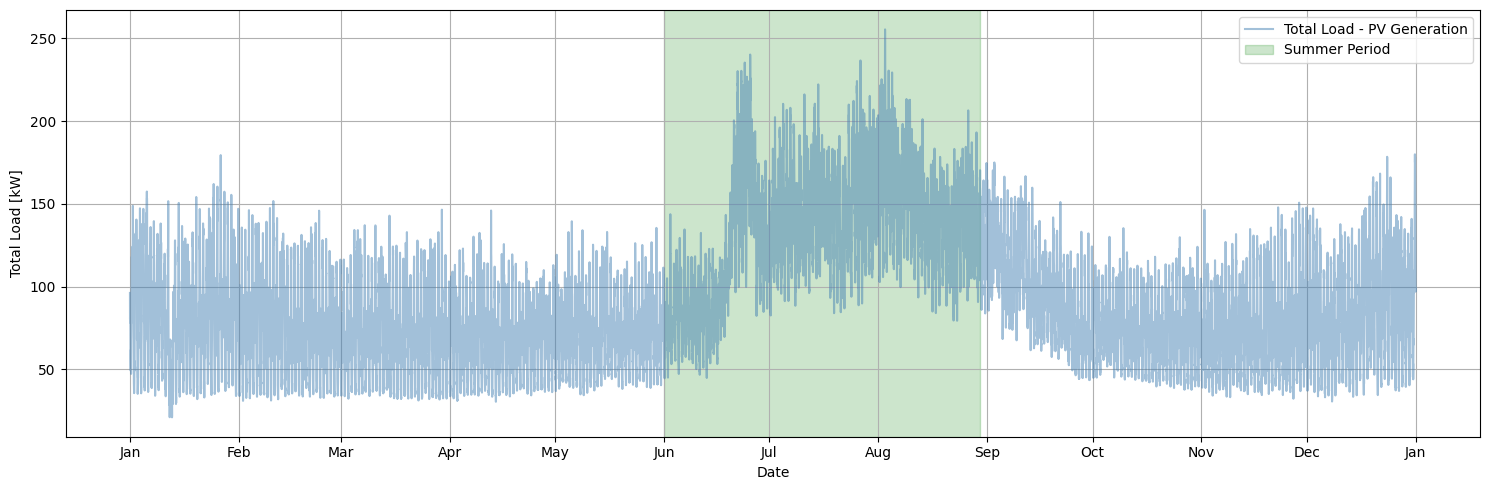

In [21]:
june_start = "2016-06-01"
june_end = "2016-06-30"

load_june = load_series[june_start:june_end]
pv_june = pv_series[june_start:june_end]

plt.figure(figsize=(15, 5))
# plt.plot(load_series, color='orange', label='Total Load')
plt.plot(load_series*1.1, color='steelblue', label='Total Load - PV Generation',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Total Load [kW]")
plt.grid(True)

# Highlight summer period
plt.axvspan(pd.Timestamp('2016-06-01'), pd.Timestamp('2016-08-30'), 
            color='green', alpha=0.2, label='Summer Period')
# Format x-axis to show only month names
month_formatter = mdates.DateFormatter('%b')  # e.g. Jan, Feb, ...
plt.legend()
plt.gca().xaxis.set_major_formatter(month_formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()
plt.show()



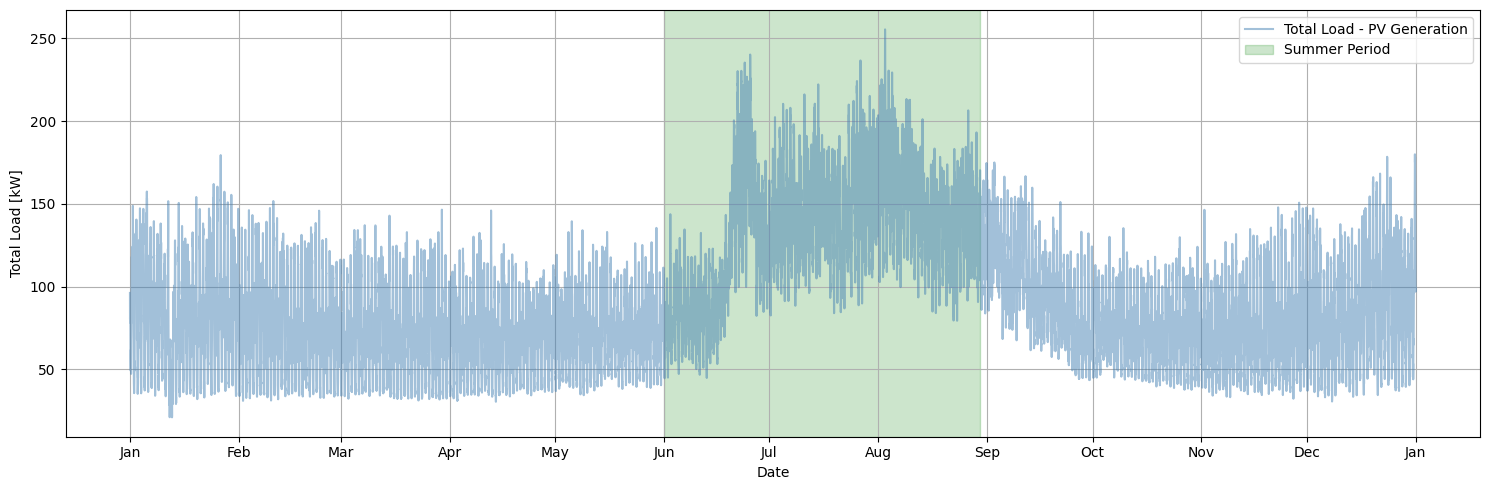

In [22]:
june_start = "2016-06-01"
june_end = "2016-06-30"

load_june = load_series[june_start:june_end]
pv_june = pv_series[june_start:june_end]

plt.figure(figsize=(15, 5))
# plt.plot(load_series, color='orange', label='Total Load')
plt.plot(load_series*1.1, color='steelblue', label='Total Load - PV Generation',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Total Load [kW]")
plt.grid(True)

# Highlight summer period
plt.axvspan(pd.Timestamp('2016-06-01'), pd.Timestamp('2016-08-30'), 
            color='green', alpha=0.2, label='Summer Period')
# Format x-axis to show only month names
month_formatter = mdates.DateFormatter('%b')  # e.g. Jan, Feb, ...
plt.legend()
plt.gca().xaxis.set_major_formatter(month_formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()
plt.show()



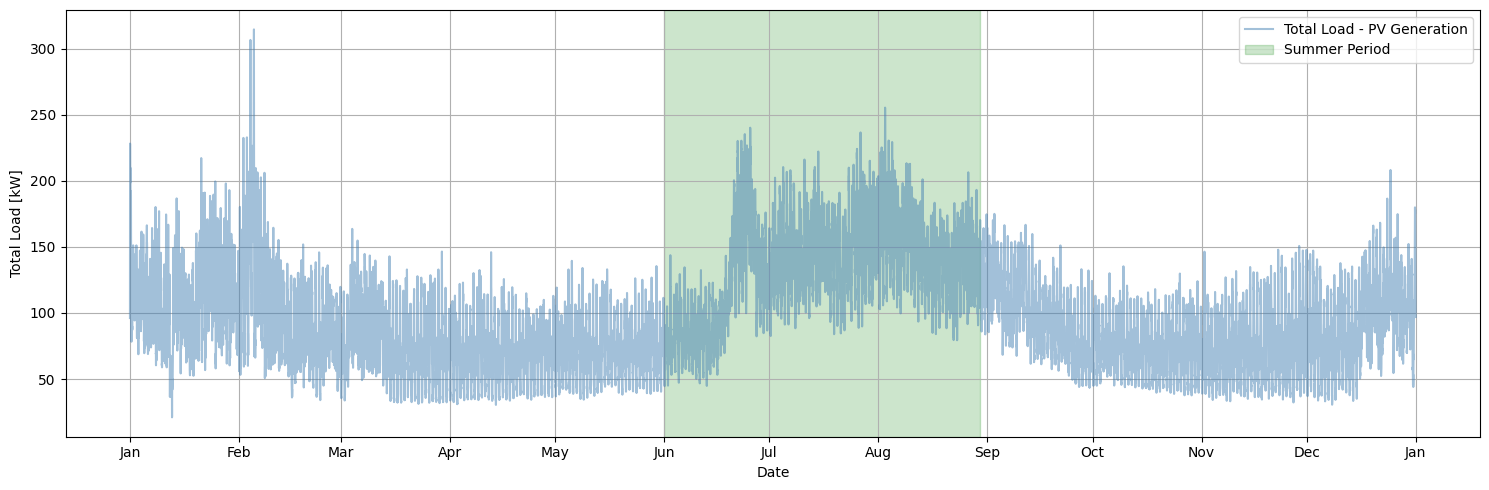

In [23]:
june_start = "2016-06-01"
june_end = "2016-06-30"

load_june = load_series[june_start:june_end]
pv_june = pv_series[june_start:june_end]

plt.figure(figsize=(15, 5))
# plt.plot(load_series, color='orange', label='Total Load')
plt.plot(load_series*1.1+Thermal_Power_combined['Power']*90*5, color='steelblue', label='Total Load - PV Generation',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Total Load [kW]")
plt.grid(True)

# Highlight summer period
plt.axvspan(pd.Timestamp('2016-06-01'), pd.Timestamp('2016-08-30'), 
            color='green', alpha=0.2, label='Summer Period')
# Format x-axis to show only month names
month_formatter = mdates.DateFormatter('%b')  # e.g. Jan, Feb, ...
plt.legend()
plt.gca().xaxis.set_major_formatter(month_formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()
plt.show()

